In [5]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [2]:
def series_n(T, σ=1.0, φ=0.5):
    y = np.zeros(T)
    for t in range(1, T):
        y[t] = φ*y[t-1] + np.random.randn()*σ
    return y

def series_c(T, μ=10.0, σ=1.0, φ=0.5):
    y = np.zeros(T)
    for t in range(1, T):
        y[t] = μ + φ*y[t-1] + np.random.randn()*σ
    return y

def series_ct(T, μ=1.0, β=0.1, σ=1.0, φ=0.5):
    y = np.zeros(T)
    for t in range(1, T):
        y[t] = μ + β*t + φ*y[t-1] + np.random.randn()*σ
    return y

def series_ctt(T, μ=1.0, β1=0.1, β2=0.0001, σ=1.0, φ=0.5):
    y = np.zeros(T)
    for t in range(1, T):
        y[t] = μ + β1*t + β2*t*t + φ*y[t-1] + np.random.randn()*σ
    return y

def series_seasonal(T, μ=0.0, A=5.0, p=50, σ=1.0, φ=0.5):
    y = np.zeros(T)
    for t in range(1, T):
        seasonal = A * np.sin(2*np.pi*t/p)
        y[t] = μ + seasonal + φ*y[t-1] + np.random.randn()*σ
    return y

def random_walk(T):
    return np.cumsum(np.random.randn(T))

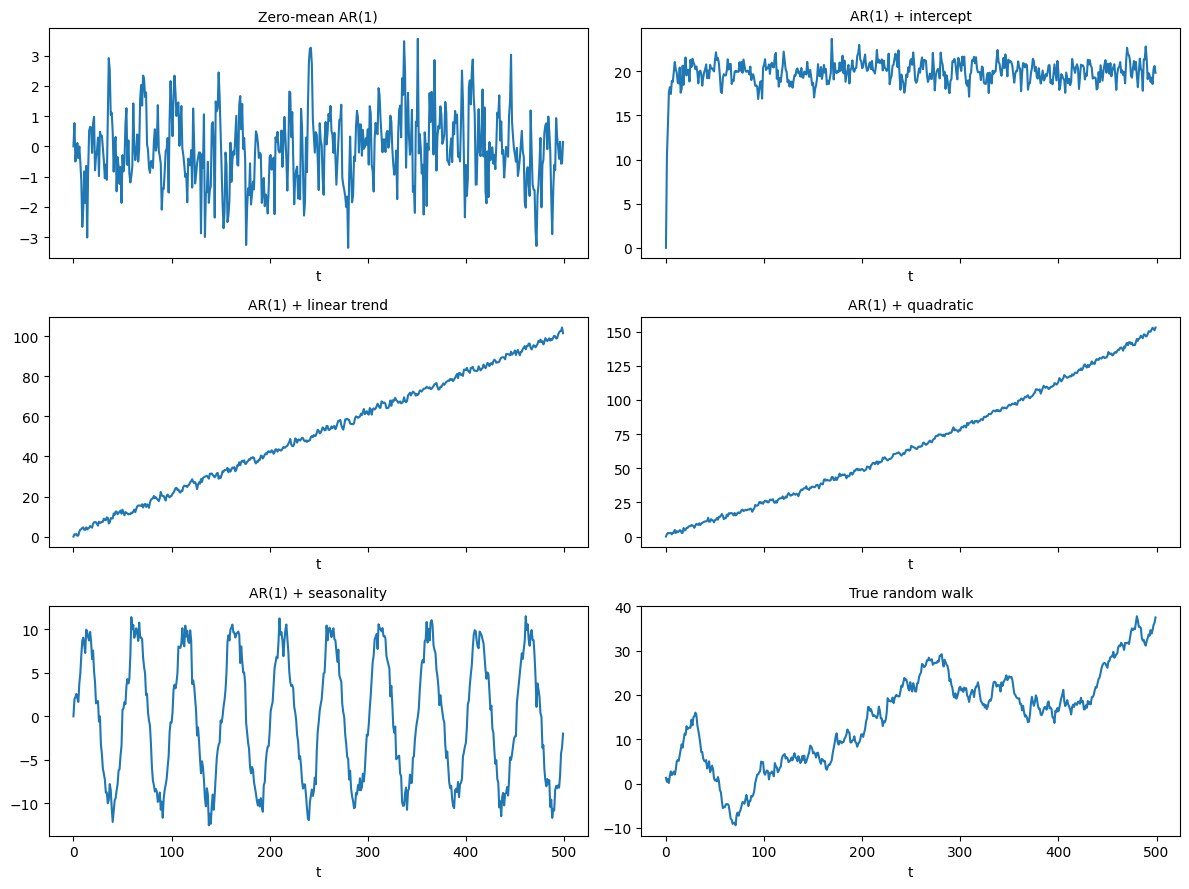

In [3]:
T = 500
t = np.arange(T)
np.random.seed(654321)

series_dict = {
    'Zero-mean AR(1)':      series_n(T),
    'AR(1) + intercept':    series_c(T),
    'AR(1) + linear trend': series_ct(T),
    'AR(1) + quadratic':    series_ctt(T),
    'AR(1) + seasonality':  series_seasonal(T),
    'True random walk':     random_walk(T),
}

# --- 3×2 grid plot ---
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 9), sharex=True)
axes = axes.ravel()           # flatten 2-D array → 1-D list

for ax, (name, series) in zip(axes, series_dict.items()):
    ax.plot(t, series)
    ax.set_title(name, fontsize=10)
    ax.set_xlabel('t')

plt.tight_layout()
plt.show()

In [4]:
# Setup
np.random.seed(654321)
series_funcs = {
    'zero-mean AR(1)': series_n,
    'AR(1) + intercept': series_c,
    'AR(1) + linear trend': series_ct,
    'AR(1) + quad trend': series_ctt,
    'AR(1) + seasonality': series_seasonal,
    'True random walk': random_walk,
}
regressions = ['n', 'c', 'ct', 'ctt']

# Run tests
results = []
for name, func in series_funcs.items():
    x = func(T)
    row = {'Series': name}
    for reg in regressions:
        stat, pvalue, usedlag, nobs, crit = adfuller(x, maxlag=0, regression=reg, autolag=None)
        row[f'{reg}_stat'] = stat
        row[f'{reg}_pvalue'] = pvalue
    results.append(row)

df_results = pd.DataFrame(results).set_index('Series')

# Settings
cols = ['n', 'c', 'ct', 'ctt']
alpha = 0.05

# Build header
header = f"{'Series':<25s}" + "".join(f"{col:>10s}" for col in cols) + f"{'Summary':>12s}"
separator = "-" * len(header)

print(header)
print(separator)

# Print rows
for series_name, row in df_results.iterrows():
    # Gather p-values and rejection flags
    pvals = [row[f"{col}_pvalue"] for col in cols]
    rejects = ['Y' if p < alpha else 'n' for p in pvals]
    summary = "".join(rejects)  # e.g. 'Ynnn'
    # Format p-values to three decimal places
    line = f"{series_name:<25s}"
    for p in pvals:
        line += f"{p:>10.3f}"
    line += f"{summary:>12s}"
    print(line)

Series                            n         c        ct       ctt     Summary
-----------------------------------------------------------------------------
zero-mean AR(1)               0.000     0.000     0.000     0.000        YYYY
AR(1) + intercept             0.564     0.000     0.000     0.000        nYYY
AR(1) + linear trend          1.000     0.882     0.000     0.000        nnYY
AR(1) + quad trend            1.000     0.992     0.162     0.000        nnnY
AR(1) + seasonality           0.020     0.167     0.420     0.667        Ynnn
True random walk              0.935     0.918     0.767     0.923        nnnn
